In [67]:
import os

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['font.family']='AppleGothic'

import warnings
warnings.filterwarnings(action='ignore')

In [68]:
def read_csv_by_dir(path, index_col=None):
    df_raw = pd.DataFrame()
    for files in os.listdir(path):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path,files]),
                            index_col=index_col)
        df_raw = pd.concat((df_raw,df),axis=0)
    return df_raw

In [69]:
path = 'data'
_df_rf_raw = read_csv_by_dir('/'.join([path,'rf_data']),
                            index_col=0)

_df_water_raw = read_csv_by_dir('/'.join([path,'water_data']),
                               index_col=0)

_submission_raw = pd.read_csv('/'.join([path,'sample_submission.csv']),
                             index_col=0)

In [70]:
# raw_data 보존하기
df_rf=_df_rf_raw.copy()
df_rf.name = "rain_data"

df_water=_df_water_raw.copy()
df_water.name = "water_data"

submission=_submission_raw.copy()
submission.name = "submission"

In [71]:
def index_to_datetime(df,format):
    df.index = pd.to_datetime(df.index,
                              format=format)
    return df

In [72]:
df_rf=index_to_datetime(df=df_rf,format='%Y-%m-%d %H:%M')
df_water=index_to_datetime(df=df_water,format='%Y-%m-%d %H:%M')
submission=index_to_datetime(df=submission,format='%Y-%m-%d %H:%M')

In [73]:
df_rf.sort_index(inplace=True)
df_water.sort_index(inplace=True)
submission.sort_index(inplace=True)

In [74]:
# 데이터 시간대 확인하기
def check_datetime(df):
    print(df.name)
    print(df.select_dtypes('datetime64[ns]').head(1).index[0])
    print(df.select_dtypes('datetime64[ns]').tail(1).index[0])
    return None

check_datetime(df_rf)
check_datetime(df_water)
check_datetime(submission)

rain_data
2012-05-01 00:00:00
2022-07-18 23:50:00
water_data
2012-05-01 00:00:00
2022-07-18 23:50:00
submission
2022-06-01 00:00:00
2022-07-18 23:50:00


In [75]:
# data target 분리하기
target = df_water.loc[:,submission.columns]
data = pd.concat((df_rf,df_water.drop(submission.columns,axis=1)),axis=1)

In [76]:
# data와 target 하나 밀어주기 (과거데이터를 사용해야 함으로)
_target = target.reset_index(drop=True)
_data = data.reset_index(drop=True)

_data.index += 1

tot=pd.concat((_data,_target),axis=1)
tot=tot.sort_index()

tot=tot.iloc[1:-1]

target = tot.loc[:,submission.columns]
data = tot.drop(submission.columns,axis=1)

In [77]:
train_target=target.iloc[:-len(submission),:]
test_target=target.iloc[-len(submission):,:]

train_data=data.iloc[:-len(submission),:]
test_data=data.iloc[-len(submission):,:]

In [102]:
train_target.fillna(train_target.mean(),inplace=True)
test_target.fillna(train_target.mean(),inplace=True)
train_data.fillna(train_data.mean(),inplace=True)
test_data.fillna(train_data.mean(),inplace=True)

In [112]:
print(train_target)
print(train_data)

        wl_1018662  wl_1018680  wl_1018683  wl_1019630
1            314.7       300.2       290.0       275.3
2            313.7       301.2       290.0       275.3
3            311.7       301.2       290.0       276.3
4            311.7       301.2       291.0       277.3
5            311.7       301.2       291.0       277.3
...            ...         ...         ...         ...
269419       281.7       281.2       278.0       271.3
269420       279.7       279.2       278.0       272.3
269421       278.7       277.2       277.0       272.3
269422       277.7       276.2       276.0       271.3
269423       278.7       276.2       275.0       270.3

[269423 rows x 4 columns]
        rf_10184100  rf_10184110  rf_10184140     swl     inf     sfw   ecpc  \
1               0.0          0.0          0.0  24.800  555.00  219.07  24.93   
2               0.0          0.0          0.0  24.794  464.60  218.86  25.15   
3               0.0          0.0          0.0  24.789  478.10  218.69  25

        rf_10184100  rf_10184110  rf_10184140     swl     inf     sfw   ecpc  \
1               0.0          0.0          0.0  24.800  555.00  219.07  24.93   
2               0.0          0.0          0.0  24.794  464.60  218.86  25.15   
3               0.0          0.0          0.0  24.789  478.10  218.69  25.31   
4               0.0          0.0          0.0  24.789  464.80  218.69  25.31   
5               0.0          0.0          0.0  24.789  478.10  218.69  25.31   
...             ...          ...          ...     ...     ...     ...    ...   
269419          0.0          0.0          0.0  25.180  140.89  217.99  26.01   
269420          0.0          0.0          0.0  25.180  140.94  217.99  26.01   
269421          0.0          0.0          0.0  25.180  141.07  217.99  26.01   
269422          0.0          0.0          0.0  25.180  141.01  217.99  26.01   
269423          0.0          0.0          0.0  25.190  755.75  218.36  25.64   

        tototf  tide_level  fw_1018662 

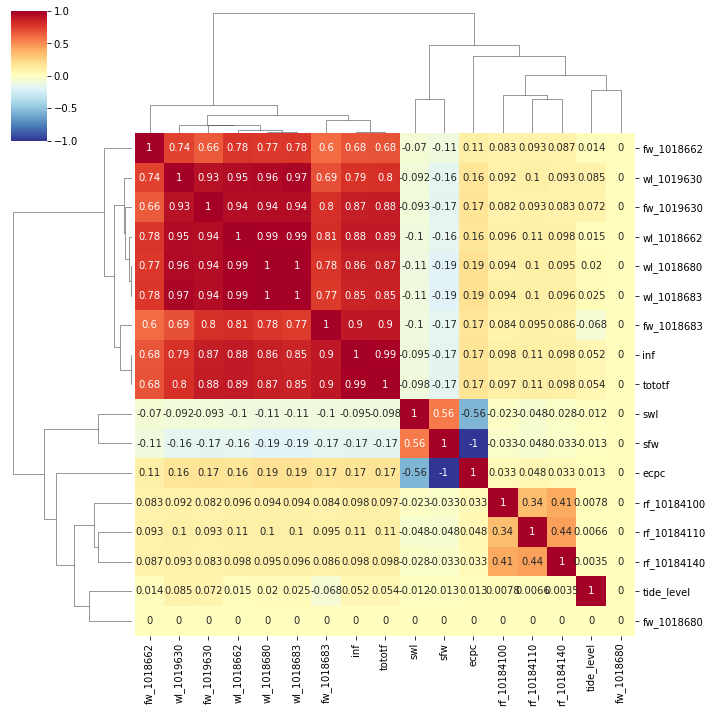

In [116]:
import seaborn as sns
from icecream import ic
df = pd.concat([train_data, train_target],axis=1)
print(df)
df_corr = df.corr()
print(df_corr)
df_corr.fillna(0,inplace=True)
sns.clustermap(df_corr, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [79]:
print('--data--')
print(train_data.shape)
print(test_data.shape)
print('--target--')
print(train_target.shape)
print(test_target.shape)

--data--
(269423, 13)
(6912, 13)
--target--
(269423, 4)
(6912, 4)


In [80]:
print('--data--')
print(train_data.shape)
print(test_data.shape)
print('--target--')
print(train_target.shape)
print(test_target.shape)

--data--
(269423, 13)
(6912, 13)
--target--
(269423, 4)
(6912, 4)


In [89]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=2, shuffle=True)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

params = {
    "n_estimators" : (100, 150, 200, 400, 500)
}

from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(train_data, train_target, train_size=0.7, random_state=42)

In [91]:
from sklearn.model_selection import GridSearchCV
grid_cv = GridSearchCV(rf,
                       param_grid=params,
                       cv = kfold,
                       n_jobs=-1)

In [93]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_estimators': (100, 150, 200)})

In [94]:
grid_cv.best_estimator_

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [95]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(train_data, train_target, train_size=0.7, random_state=42)

In [96]:
from sklearn.metrics import r2_score
model = grid_cv.best_estimator_
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
# print(y_val)
# print(y_pred)
print(r2_score(y_val, y_pred))

        wl_1018662  wl_1018680  wl_1018683  wl_1019630
28105        304.7       296.2       290.0       282.3
189381       281.7       270.2       270.0       256.3
158998       317.7       300.2       304.0       290.3
154333       276.7       261.2       265.0       256.3
31023        287.7       280.2       273.0       264.3
...            ...         ...         ...         ...
232072       342.7       351.2       335.0       318.3
6331         283.7       276.2       266.0       253.3
164803       304.7       289.2       292.0       287.3
135924       303.7       294.2       297.0       295.3
29451        313.7       299.2       292.0       282.3

[80827 rows x 4 columns]
[[303.035 292.305 288.905 281.685]
 [282.425 269.68  269.135 256.435]
 [317.485 305.33  304.325 289.545]
 ...
 [305.915 292.165 294.635 287.11 ]
 [307.22  295.675 298.245 295.635]
 [314.745 298.325 293.6   282.455]]
0.9979021507019095


In [88]:
model = grid_cv.best_estimator_
model.fit(train_data,train_target)
y_pred = model.predict(test_data)
_submission_raw.iloc[:,:] = y_pred
_submission_raw.to_csv('ans.csv')